LOAD THE DATASETS

In [ ]:
import pandas as pd
import numpy as np
import re

from google.colab import drive
drive.mount('/content/drive')

# 1. LOAD ORIGINAL MESSY FILES
df_resale = pd.read_csv('/content/drive/MyDrive/WIA1007_Assignment/resale_car.csv')
df_compiled = pd.read_csv('/content/drive/MyDrive/WIA1007_Assignment/Malaysia_Final_CarList_Compiled.csv')

# 2. INTELLIGENT EXTRACTION FUNCTION (Fixes 'Unknown' models)
def extract_make_model(row):
    desc = str(row['Description'])
    model_col = str(row['Model'])
    words = desc.split()
    model_col = str(row['Model'])
    words = desc.split()

    # If original Model column is not empty, use it
    if model_col and model_col != 'nan':
        make = model_col.split()[0]
        model = model_col
    else:
        # RESCUE: Extract from description (Format: 2014 Brand Model ...)
        try:
            make = words[1]
            model = words[1] + " " + words[2]
        except:
            make, model = "Unknown", "Unknown"
    return make, model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CLEANING 'resale_car.csv' DATASET

In [ ]:
df_resale['Year'] = df_resale['Description'].apply(lambda x: int(re.search(r'(\d{4})', str(x)).group(1)) if re.search(r'(\d{4})', str(x)) else np.nan)
df_resale['Price'] = df_resale['Price (RM)'].replace(r'[RM, ]', '', regex=True).astype(float)
df_resale['Mileage'] = df_resale['Mileage'].apply(lambda x: (int(re.findall(r'\d+', str(x))[0]) + int(re.findall(r'\d+', str(x))[1])) * 500 if len(re.findall(r'\d+', str(x))) == 2 else np.nan)

extracted = df_resale.apply(extract_make_model, axis=1)
df_resale['Make'] = [x[0] for x in extracted]
df_resale['Model_Clean'] = [x[1] for x in extracted]
df_resale['Brand_Origin'] = df_resale['Make'].apply(lambda x: 'Local' if str(x).upper() in ['PROTON', 'PERODUA'] else 'Foreign')

# Filter out anything that still failed to be rescued
resale_clean = df_resale[df_resale['Model_Clean'] != 'Unknown'][['Make', 'Model_Clean', 'Year', 'Price', 'Mileage', 'Gear_Type', 'Brand_Origin']]
resale_clean.columns = ['Make', 'Model', 'Year', 'Price', 'Mileage', 'Gear_Type', 'Brand_Origin']

CLEANING 'Malaysia_Final_CarList_Compiled.csv' DATASET

In [ ]:
# 4. CLEANING 'Malaysia_Final_CarList_Compiled.csv'
compiled_clean = df_compiled[['Make', 'Model', 'Year', 'Price', 'Mileage', 'Transm']].copy()
compiled_clean.rename(columns={'Transm': 'Gear_Type'}, inplace=True)
compiled_clean['Brand_Origin'] = 'Local'

 MERGE & BALANCE

In [ ]:
df_merged = pd.concat([resale_clean, compiled_clean], ignore_index=True)
df_merged[['Year', 'Mileage', 'Price']] = df_merged[['Year', 'Mileage', 'Price']].fillna(df_merged[['Year', 'Mileage', 'Price']].median())
df_merged['Car_Age'] = 2025 - df_merged['Year']

# Force 50/50 Balance
df_foreign = df_merged[df_merged['Brand_Origin'] == 'Foreign']
df_local = df_merged[df_merged['Brand_Origin'] == 'Local']
df_final = pd.concat([df_foreign.sample(2000, replace=True), df_local.sample(2000, replace=True)]).sample(frac=1).reset_index(drop=True)

EXPORT THE DATASET TO CSV/EXCEL

In [ ]:
# 6. EXPORT
df_final.to_csv(
    '/content/drive/MyDrive/WIA1007_Assignment/cleaned_balanced_4000_final.csv',
    index=False)
df_final.to_excel(
    '/content/drive/MyDrive/WIA1007_Assignment/cleaned_balanced_4000_final.xlsx',
    index=False)
print("Final Cleaned & Balanced Dataset Created with 0 Unknowns!")


Final Cleaned & Balanced Dataset Created with 0 Unknowns!


CREATING TABLE 1 PROPERTIES

In [ ]:
import pandas as pd

# 1. Load dataset
df_final = pd.read_csv('/content/drive/MyDrive/WIA1007_Assignment/cleaned_balanced_4000_final.csv')

# 2. Function
def generate_assignment_table_1(df):
    table_1_data = []

    for col in df.columns:
        is_num = pd.api.types.is_numeric_dtype(df[col])

        type_of_data = 'Numeric' if is_num else 'Categorical'
        measurement_level = 'Ratio' if is_num else 'Nominal'

        min_val = df[col].min() if is_num else "N/A"
        max_mode = df[col].max() if is_num else df[col].mode()[0]

        table_1_data.append({
            'Variable': col,
            'Types of Data': type_of_data,
            'Data Types': str(df[col].dtype),
            'Measurement Level': measurement_level,
            'Min Value': min_val,
            'Max/Mode Value': max_mode,
            'Unique Values': df[col].nunique(),
            'Null Values': df[col].isnull().sum(),
            'Outliers': 'Yes (Check Boxplot)' if is_num else 'No'
        })

    return pd.DataFrame(table_1_data)

# 3. Create table
table_1 = generate_assignment_table_1(df_final)

# 4. Display
print("--- TABLE 1: DATA PROPERTIES ---")
display(table_1)

# 5. Export
table_1.to_excel(
    '/content/drive/MyDrive/WIA1007_Assignment/Table_1_Data_Properties.xlsx',
    index=False)

--- TABLE 1: DATA PROPERTIES ---


,Variable,Types of Data,Data Types,Measurement Level,Min Value,Max/Mode Value,Unique Values,Null Values,Outliers
0,Make,Categorical,object,Nominal,N/A,Perodua,31,0,No
1,Model,Categorical,object,Nominal,N/A,Myvi,198,0,No
2,Year,Numeric,int64,Ratio,1995,2022,27,0,Yes (Check Boxplot)
3,Price,Numeric,int64,Ratio,3700,1130000,856,0,Yes (Check Boxplot)
4,Mileage,Numeric,int64,Ratio,2500,300000,135,0,Yes (Check Boxplot)
5,Gear_Type,Categorical,object,Nominal,N/A,Automatic,2,0,No
6,Brand_Origin,Categorical,object,Nominal,N/A,Foreign,2,0,No
7,Car_Age,Numeric,int64,Ratio,3,30,27,0,Yes (Check Boxplot)


CREATING TABLE 2 DATA STATISTICS

In [ ]:
import pandas as pd
import numpy as np

# Load cleaned dataset from Drive
df_final = pd.read_csv('/content/drive/MyDrive/WIA1007_Assignment/cleaned_balanced_4000_final.csv')

def generate_table_2(df):
    numeric_df = df.select_dtypes(include=[np.number])
    stats = numeric_df.describe().T
    stats['Skewness'] = numeric_df.skew()
    stats['Kurtosis'] = numeric_df.kurt()

    table_2 = stats[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Skewness', 'Kurtosis']]
    table_2 = table_2.rename(columns={
        'mean': 'Mean',
        'std': 'Standard Deviation',
        'min': 'Min',
        '50%': 'Median',
        'max': 'Max'
    })

    table_2 = table_2.round(4)
    table_2.index.name = 'Variable'
    return table_2

# Create Table 2
table_2_tidy = generate_table_2(df_final)

# Display in Colab
print("--- TABLE 2: DATA STATISTICS ---")
display(table_2_tidy)

# Export to Excel (Google Drive)
table_2_tidy.to_excel(
    '/content/drive/MyDrive/WIA1007_Assignment/Table_2_Statistics.xlsx',
    sheet_name='Statistics')

--- TABLE 2: DATA STATISTICS ---


,Mean,Standard Deviation,Min,25%,Median,75%,Max,Skewness,Kurtosis
Variable,,,,,,,,,
Year,2013.8135,4.0749,1995.0,2013.0,2014.0,2016.0,2022.0,-1.0195,1.7762
Price,72962.0215,83388.3847,3700.0,31999.0,47800.0,75800.0,1130000.0,3.6317,19.2047
Mileage,78373.9868,30346.2202,2500.0,67500.0,77500.0,92500.0,300000.0,0.7394,4.4722
Car_Age,11.1865,4.0749,3.0,9.0,11.0,12.0,30.0,1.0195,1.7762


OUTLIER DETECTION USING BOXPLOTS

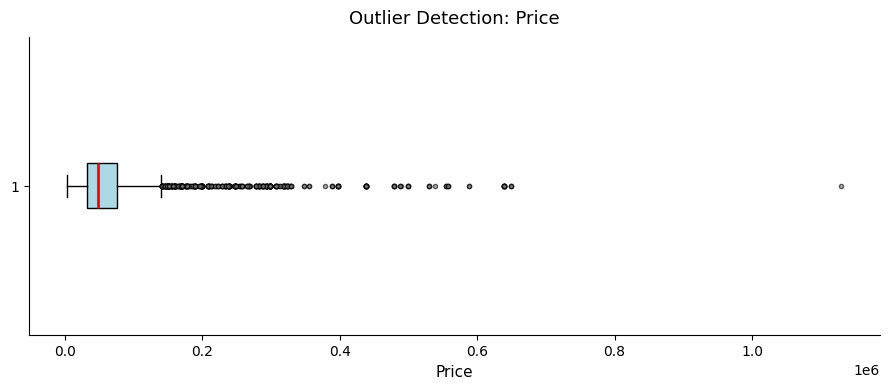

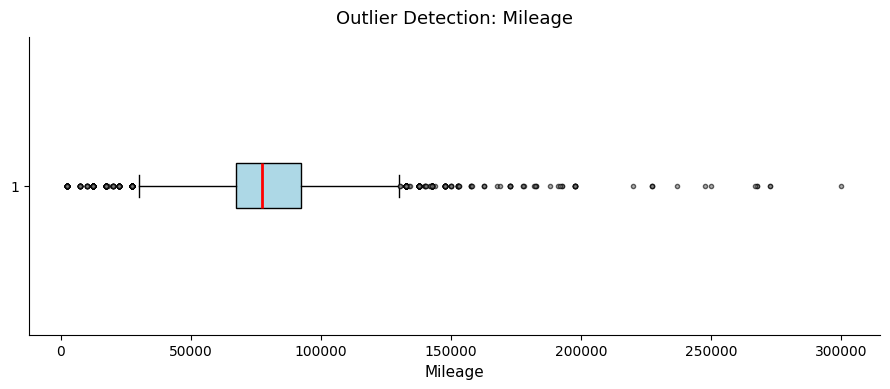

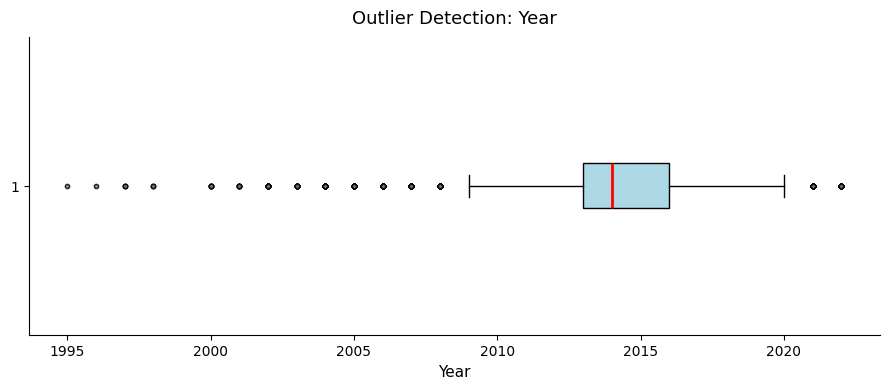

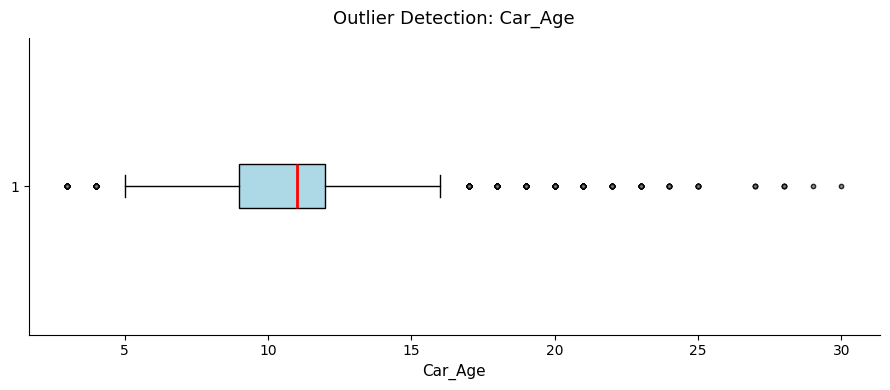

In [ ]:
import matplotlib.pyplot as plt

numeric_cols = ['Price', 'Mileage', 'Year', 'Car_Age']

#simple and clean
plt.style.use('default')

for col in numeric_cols:
    plt.figure(figsize=(9, 4))  # Wider for readability

    plt.boxplot(
        df_final[col],
        vert=False,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', edgecolor='black'),
        medianprops=dict(color='red', linewidth=2),
        flierprops=dict(marker='o', markersize=3, markerfacecolor='gray', alpha=0.6)
    )

    plt.title(f'Outlier Detection: {col}', fontsize=13, pad=10)
    plt.xlabel(col, fontsize=11)

    # Remove unnecessary borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


Observation:
*   The Price boxplot shows a wide spread with several high-value outliers on the upper end.

*   The Mileage boxplot displays right-skewness with multiple upper outliers.

*   The Year variable shows a concentration of values around recent years, with a few older vehicles appearing as lower-end outliers.
*  The Car_Age boxplot indicates a right-skewed distribution with several high-age outliers.